<a href="https://colab.research.google.com/github/ppunkz/gold-price-forecasting/blob/master/LSTM_gold_price_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
%matplotlib inline
%config InlineBackend.figure_format='retina'

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded = files.upload()

Saving goldprice.csv to goldprice.csv


In [4]:
Col = ['Date','Price']
df = pd.read_csv('goldprice.csv', parse_dates=['Date'], index_col='Date', usecols=Col)

In [5]:
df = df.sort_values('Date')
df = df.dropna()

In [6]:
df.describe()

,Price
count,4957.000000
mean,976.419024
std,463.623172
min,255.100006
25%,446.700012
50%,1135.199951
75%,1312.400024
max,1888.699951


In [8]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, train_size=.9, shuffle=False)

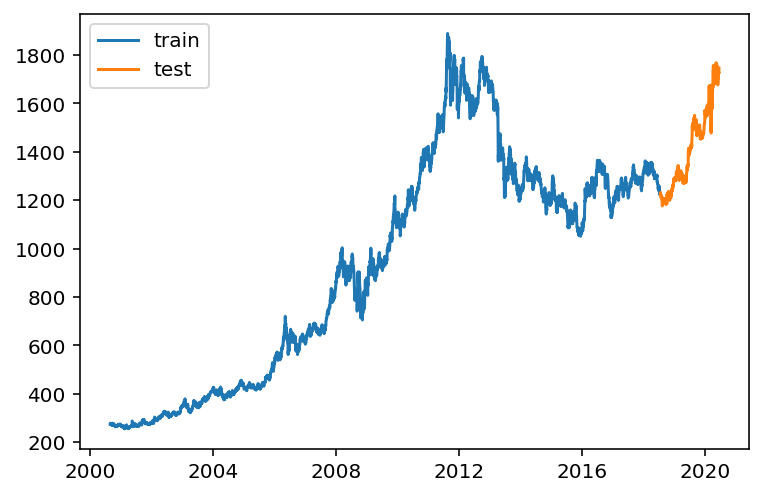

In [9]:
#plt.figure(figsize = (20,5))
plt.plot(train, label = 'train')
plt.plot(test, label = 'test')
plt.legend()
plt.show()

In [10]:
print(train.shape)
print(test.shape)

(4461, 1)
(496, 1)


In [11]:
train_max = train.max()
train_min = train.min()

# Normalize the dataframes
train = (train - train_min)/(train_max - train_min)
test = (test - train_min)/(train_max - train_min)

In [12]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


time_steps = 3

X_train, y_train = create_dataset(train.Price, train.Price, time_steps)
X_test, y_test = create_dataset(test.Price, test.Price, time_steps)

In [13]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4458, 3, 1) (4458,)
(493, 3, 1) (493,)


In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(100, return_sequences =False, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(tf.keras.layers.Dropout(0.5))
#model.add(tf.keras.layers.LSTM(400, return_sequences= True))
#model.add(Dropout(0.2))
#model.add(tf.keras.layers.LSTM(400, return_sequences= True))
#model.add(Dropout(0.2))
#model.add(tf.keras.layers.LSTM(400, return_sequences= True))
#model.add(Dropout(0.2))
#model.add(tf.keras.layers.LSTM(600))
#model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=20, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation ='sigmoid'))
model.compile(loss='mae',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 42,841
Trainable params: 42,841
Non-trainable params: 0
_________________________________________________________________


In [16]:
history_lstm = model.fit(X_train, y_train, epochs=300, batch_size=32, validation_data = (X_test, y_test), shuffle=False)

Epoch 1/300
140/140 [==============================] - 1s 6ms/step - loss: 0.1931 - val_loss: 0.1032
Epoch 2/300
140/140 [==============================] - 1s 4ms/step - loss: 0.1536 - val_loss: 0.0891
Epoch 3/300
140/140 [==============================] - 1s 4ms/step - loss: 0.0830 - val_loss: 0.0597
Epoch 4/300
140/140 [==============================] - 1s 4ms/step - loss: 0.0602 - val_loss: 0.0514
Epoch 5/300
140/140 [==============================] - 1s 4ms/step - loss: 0.0492 - val_loss: 0.0452
Epoch 6/300
140/140 [==============================] - 1s 4ms/step - loss: 0.0500 - val_loss: 0.0447
Epoch 7/300
140/140 [==============================] - 1s 4ms/step - loss: 0.0490 - val_loss: 0.0426
Epoch 8/300
140/140 [==============================] - 1s 4ms/step - loss: 0.0494 - val_loss: 0.0396
Epoch 9/300
140/140 [==============================] - 1s 4ms/step - loss: 0.0465 - val_loss: 0.0395
Epoch 10/300
140/140 [==============================] - 1s 4ms/step - loss: 0.0473 - val_lo

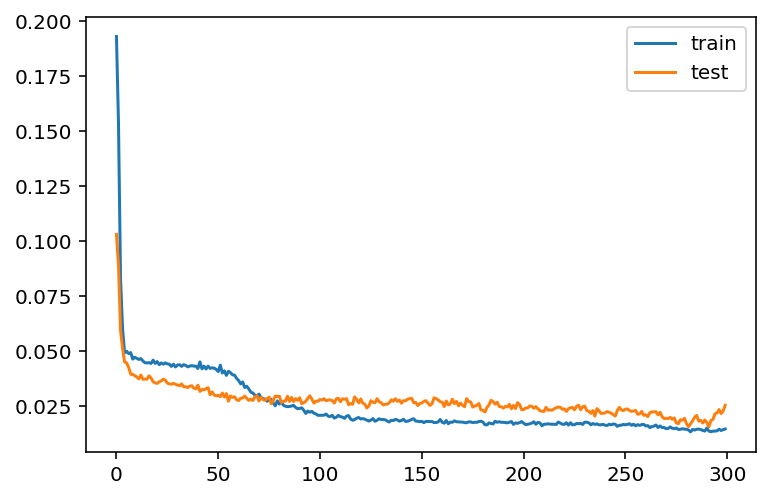

In [17]:
plt.plot(history_lstm.history['loss'], label='train')
plt.plot(history_lstm.history['val_loss'], label = 'test')
plt.legend()
plt.show()  

In [18]:
print(X_train.shape, y_train.shape)

(4458, 3, 1) (4458,)


In [19]:
#Predict the price
y_pred = model.predict(X_test)

In [20]:
# Rescale the data back to the original scale
y_test = y_test*(train_max[0] - train_min[0]) + train_min[0]
y_pred = y_pred*(train_max[0] - train_min[0]) + train_min[0]
y_train = y_train*(train_max[0] - train_min[0]) + train_min[0]

In [21]:
print('Mean absolute error (MAE):   %f' % mean_absolute_error(y_test, y_pred))
print('Mean square error (MSE):   %f' % sqrt(mean_squared_error(y_test, y_pred)))

Mean absolute error (MAE):   41.622804
Mean square error (MSE):   55.902677


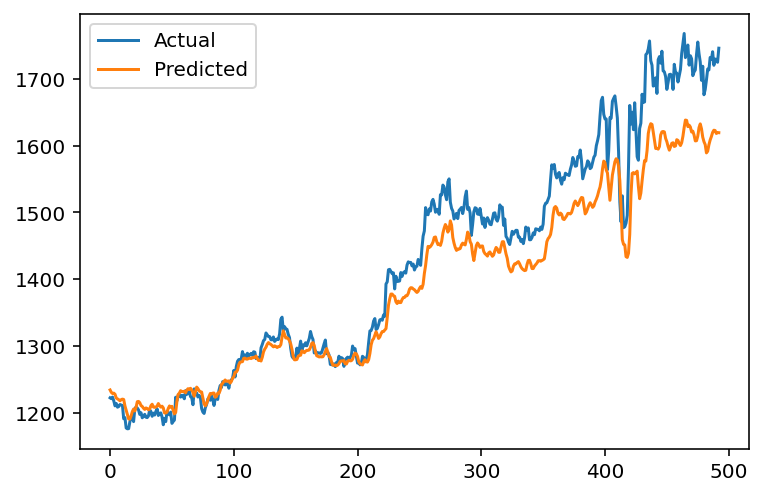

In [22]:
plt.plot(y_test, label = 'Actual')
plt.plot(y_pred, label = 'Predicted')
plt.legend()
plt.show()